In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors 

import sys
sys.path.append("../../scripts")
sys.path.append("../")
from TrackReconstruction_functions import *
from reconstruction_functions import *


In [2]:
diff = "deconv"
pressure = 5

# Load in the signal metadata
meta_40 = pd.read_hdf(f"merged/trackreco_beershebire_blobr40_reco.h5", "meta")
meta_60 = pd.read_hdf(f"merged/trackreco_beershebire_blobr60_reco.h5", "meta")
meta_80 = pd.read_hdf(f"merged/trackreco_beershebire_blobr80_reco.h5", "meta")
meta_100 = pd.read_hdf(f"merged/trackreco_beershebire_blobr100_reco.h5", "meta")
meta_110 = pd.read_hdf(f"merged/trackreco_beershebire_blobr110_reco.h5", "meta")
meta_120 = pd.read_hdf(f"merged/trackreco_beershebire_blobr120_reco.h5", "meta")
meta_130 = pd.read_hdf(f"merged/trackreco_beershebire_blobr130_reco.h5", "meta")
meta_140 = pd.read_hdf(f"merged/trackreco_beershebire_blobr140_reco.h5", "meta")


array([742169, 742883, 743954, ..., 739361, 739641, 739872],
      shape=(29935,))

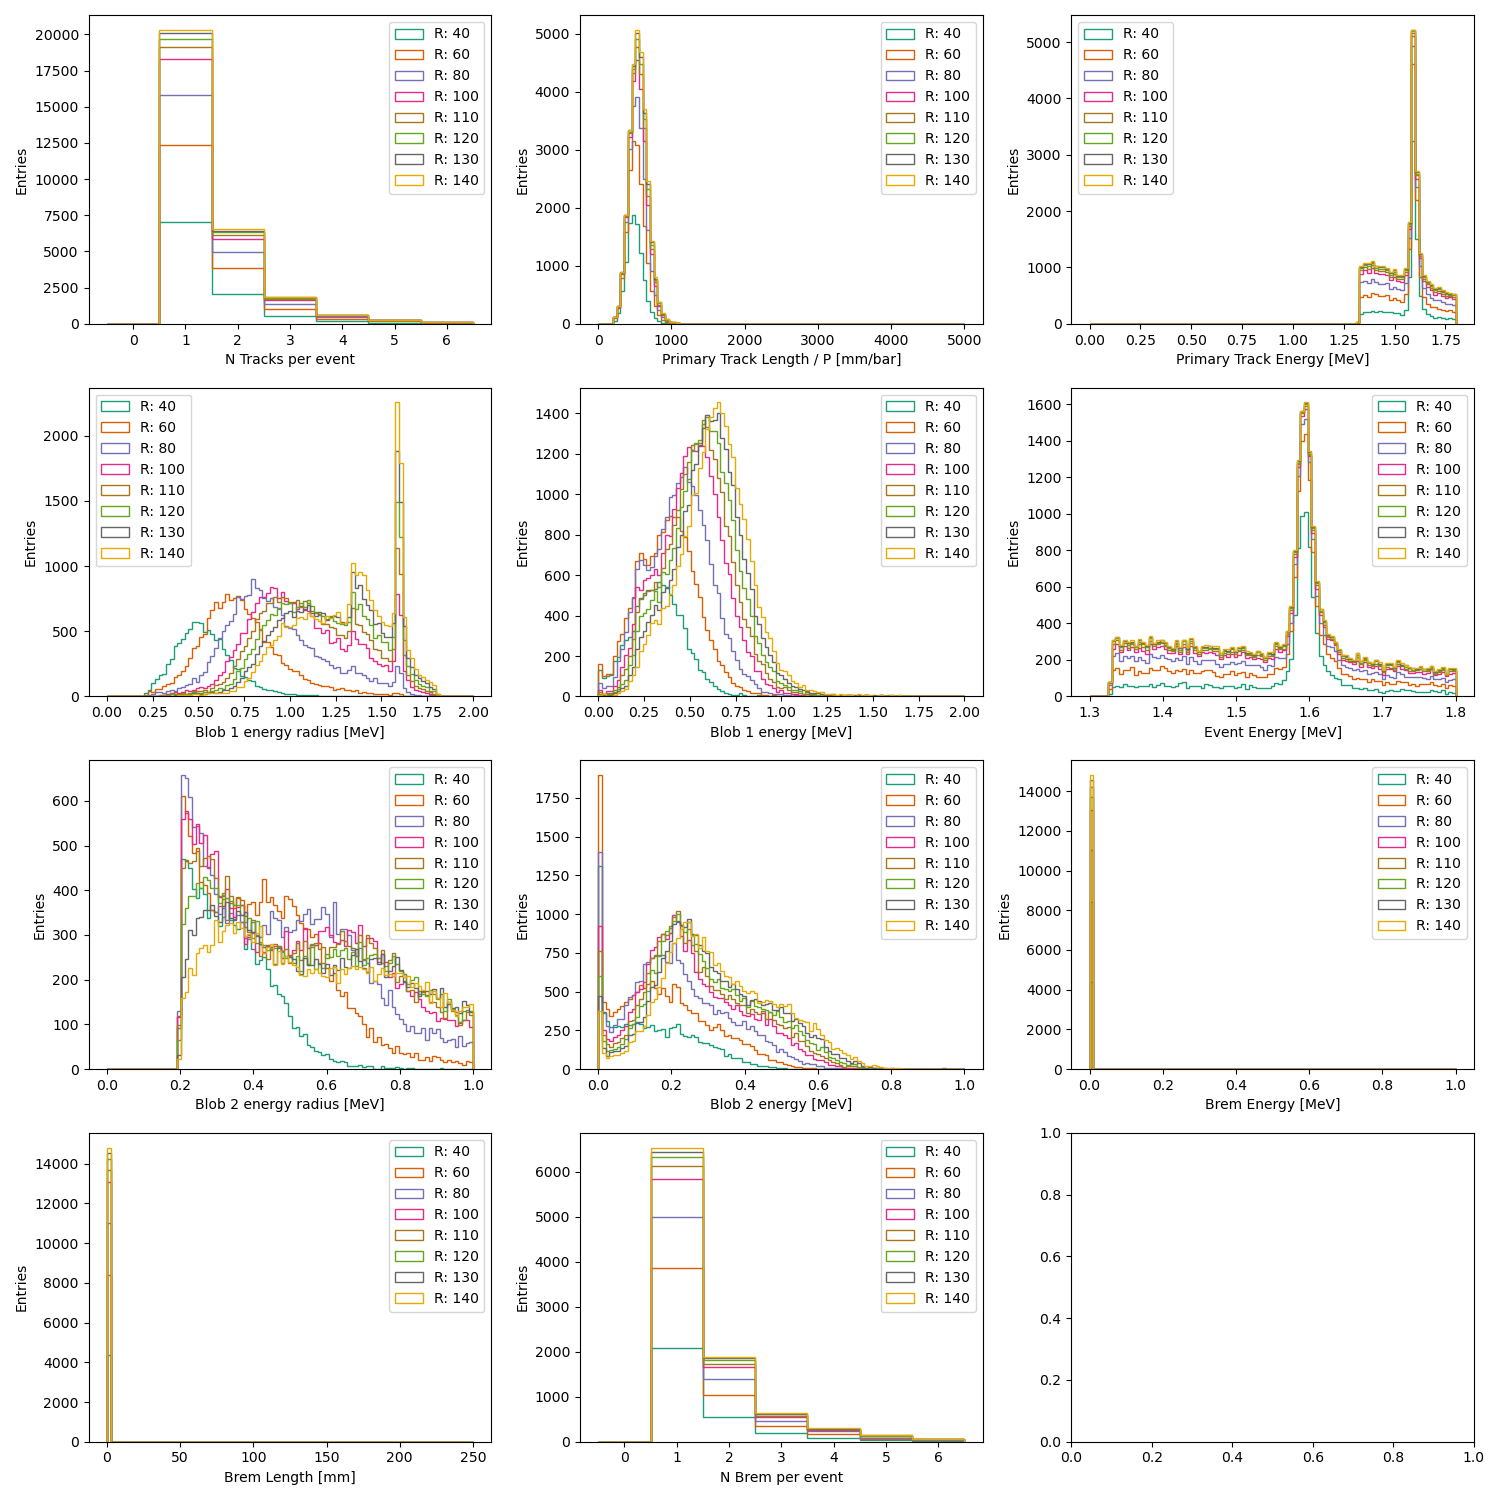

In [25]:
%matplotlib widget

def ApplyEventEnergyCut(df_meta, df_primary):

    event_energy = df_meta.groupby("event_id").energy.sum()

    good_events = event_energy[(event_energy >= 1.575) & (event_energy <= 1.61)].index 
    
    df_meta = df_meta[df_meta["event_id"].isin(good_events)]
    df_primary = df_primary[df_primary["event_id"].isin(good_events)]

    return df_meta, df_primary


def GetBrems(df_meta):
    filtered_df = df_meta[df_meta["label"].str.contains("Brem", na=False)]

    return filtered_df

def ApplyBremLenCut(df_meta, df_primary, cut):

    brems  = GetBrems(df_meta)

    brems = brems[brems.length > cut] # these are events to cut

    df_meta    = df_meta[~df_meta.event_id.isin(brems.event_id.unique())]
    df_primary = df_primary[~df_primary.event_id.isin(brems.event_id.unique())]

    return df_meta, df_primary

def ApplyBremECut(df_meta, df_primary, cut):

    brems  = GetBrems(df_meta)

    brems = brems[brems.energy > cut] # these are events to cut

    df_meta    = df_meta[~df_meta.event_id.isin(brems.event_id.unique())]
    df_primary = df_primary[~df_primary.event_id.isin(brems.event_id.unique())]

    return df_meta, df_primary


def ApplyCuts(df_meta, df_primary):

    cuts = []


    # df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary)
    df_meta, df_primary = ApplyBremLenCut(df_meta, df_primary, 1)
    df_meta, df_primary = ApplyBremECut(df_meta, df_primary, 0.01)
    # cuts = (df_primary.energy > 1.55) & (df_primary.energy < 1.65)
    cuts = (df_primary.energy > 0) & (df_primary.blob2R > 0.2)

    return df_meta, df_primary, cuts


def PlotDistributions(df_meta, col, label, pressure, scale_factor, axs, applycuts):


    # uselog=True
    uselog=False

    df_primary = df_meta[ (df_meta.label == "Primary") & (df_meta.primary == 1)]

    # Apply the cuts
    if applycuts:
        df_meta, df_primary, cuts = ApplyCuts(df_meta, df_primary)
        df_primary = df_primary[ cuts ]
        df_meta = df_meta[(df_meta.event_id.isin(df_primary.event_id.unique()))]

    event_energy = df_meta.groupby("event_id").energy.sum()

    df_counts      = GetNTracks(df_meta)

    # Number of brems and deltas
    N_brem  = GetNParticles(df_meta, "Brem")

    # Dataframes containing brems
    brems  = GetBrems(df_meta)

    weights        = np.ones_like(df_primary.energy)  * scale_factor
    weights_counts = np.ones_like(df_counts.N_tracks) * scale_factor
    weights_brem   = np.ones_like(brems.energy)       * scale_factor
    weights_Nbrem  = np.ones_like(N_brem.N_Brem)      * scale_factor
    weights_energy = np.ones_like(event_energy)       * scale_factor

    bin_edges = np.arange(-0.5, 7.5, 1)
    bin_centers = np.arange(0, 7, 1)

    # Multiplicities
    axs[0,0].hist(df_counts.N_tracks, bins = bin_edges, histtype="step", color = col, label = label, weights = weights_counts);
    # axs[0,0].hist(N_brem.N_Brem, bins = bin_edges, histtype="step", color = col, label = label);
    axs[0,0].set_xlabel("N Tracks per event")
    axs[0,0].set_ylabel("Entries")
    axs[0,0].set_xticks(bin_centers) ;
    axs[0,0].legend()
    if (uselog): axs[0,0].semilogy()

    axs[0,1].hist(df_primary.length, bins = np.linspace(0, 5000/pressure, 100), histtype="step", color = col, label = label, weights = weights);
    axs[0,1].set_xlabel("Primary Track Length / P [mm/bar]")
    axs[0,1].set_ylabel("Entries")
    axs[0,1].legend()
    if (uselog): axs[0,1].semilogy()

    axs[0,2].hist(df_primary.energy, bins = np.linspace(0,1.8,100), histtype="step", color = col, label = label, weights = weights);
    axs[0,2].set_xlabel("Primary Track Energy [MeV]")
    axs[0,2].set_ylabel("Entries")
    axs[0,2].legend()
    if (uselog): axs[0,2].semilogy()

    axs[1,1].hist(df_primary.blob1, bins = np.linspace(0, 2, 100), histtype="step", color = col, label = label, weights = weights);
    axs[1,1].set_xlabel("Blob 1 energy [MeV]")
    axs[1,1].set_ylabel("Entries")
    axs[1,1].legend()
    if (uselog): axs[1,1].semilogy()

    axs[1,2].hist(event_energy, bins = np.linspace(1.3,1.8,100), histtype="step", color = col, label = label, weights = weights_energy);
    axs[1,2].set_xlabel("Event Energy [MeV]")
    axs[1,2].set_ylabel("Entries")
    axs[1,2].legend()
    if (uselog): axs[1,2].semilogy()


    axs[2,1].hist(df_primary.blob2, bins = np.linspace(0, 1, 100), histtype="step", color = col, label = label, weights = weights);
    axs[2,1].set_xlabel("Blob 2 energy [MeV]")
    axs[2,1].set_ylabel("Entries")
    axs[2,1].legend()
    if (uselog): axs[2,1].semilogy()

    axs[2,2].hist(brems.energy, bins = np.linspace(0,1,100), histtype="step", color = col, label = label, weights = weights_brem);
    axs[2,2].set_xlabel("Brem Energy [MeV]")
    axs[2,2].set_ylabel("Entries")
    axs[2,2].legend()
    if (uselog): axs[2,2].semilogy()

    axs[1,0].hist(df_primary.blob1R, bins = np.linspace(0, 2, 100), histtype="step", color = col, label = label, weights = weights);
    axs[1,0].set_xlabel("Blob 1 energy radius [MeV]")
    axs[1,0].set_ylabel("Entries")
    axs[1,0].legend()
    if (uselog): axs[1,0].semilogy()

    axs[2,0].hist(df_primary.blob2R, bins = np.linspace(0, 1, 100), histtype="step", color = col, label = label, weights = weights);
    axs[2,0].set_xlabel("Blob 2 energy radius [MeV]")
    axs[2,0].set_ylabel("Entries")
    axs[2,0].legend()
    if (uselog): axs[2,0].semilogy()


    axs[3,0].hist(brems.length, bins = np.linspace(0,250,100), histtype="step", color = col, label = label, weights = weights_brem);
    axs[3,0].set_xlabel("Brem Length [mm]")
    axs[3,0].set_ylabel("Entries")
    axs[3,0].legend()
    if (uselog): axs[3,0].semilogy()

    axs[3,1].hist(N_brem.N_Brem, bins = bin_edges, histtype="step", color = col, label = label, weights = weights_Nbrem);
    axs[3,1].set_xlabel("N Brem per event")
    axs[3,1].set_ylabel("Entries")
    axs[3,1].set_xticks(bin_centers) ;
    axs[3,1].legend()
    if (uselog): axs[3,1].semilogy()

    plt.tight_layout()

    return df_primary.event_id.unique()

fig, axs = plt.subplots(4, 3, figsize=(15, 15))
PlotDistributions(meta_40,  "#1B9E77", f"R: 40",  1.0, 1, axs, True)
PlotDistributions(meta_60,  "#D95F02", f"R: 60",  1.0, 1, axs, True)
PlotDistributions(meta_80,  "#7570B3", f"R: 80",  1.0, 1, axs, True)
PlotDistributions(meta_100, "#E7298A", f"R: 100", 1.0, 1, axs, True)
PlotDistributions(meta_110, "#A6761D", f"R: 110", 1.0, 1, axs, True)
PlotDistributions(meta_120, "#66A61E", f"R: 120", 1.0, 1, axs, True)
PlotDistributions(meta_130, "#666666", f"R: 130", 1.0, 1, axs, True)
PlotDistributions(meta_140, "#E6AB02", f"R: 140", 1.0, 1, axs, True)
